# **Importing Libraries**

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize  # Used for resizing images
from skimage.io import imread, imshow  # For reading and displaying images
from tensorflow import keras  # For building and managing neural networks

# **Pure Images from Dataset**

Shape of training data (images): (1328, 512, 512, 3)
Data type of images: uint8


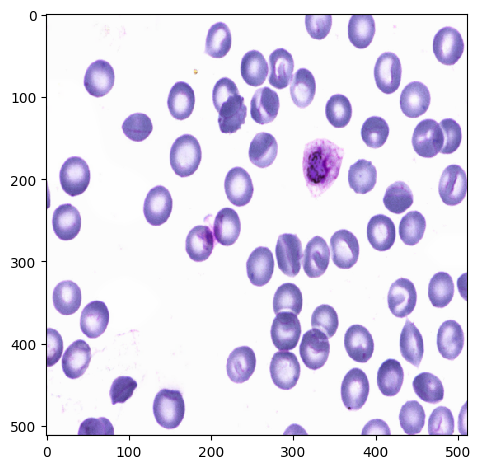

In [2]:
# Define the image dimensions
row = 512  # Height of the image
columns = 512  # Width of the image

# Load the training images from the directory
train_data_path = '/kaggle/input/blooddata/Original'  # Path to training images
training_images = os.listdir(train_data_path)  # List of image filenames
training_images.sort()  # Sort images for consistency

# Initialize an array to hold the images
# X: A numpy array to store all images, with shape (number_of_images, height, width, channels)
X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)  # Initialize with zeros

# Loop through the images, resize them, and store them in the X array
index = 0
for x in training_images:
    path = os.path.join(train_data_path, x)  # Get the full path of the image
    image = imread(path)  # Read the image from the path
    image = resize(image, (row, columns), mode='constant', preserve_range=True)  # Resize the image
    X[index] = image  # Store the resized image in the X array
    index += 1  # Increment index

# Output the shape of the loaded images array
print("Shape of training data (images):", X.shape)

# Check the data type of the images array
print("Data type of images:", X.dtype)

# Visualize the first image in the dataset to verify
imshow(X[0])
plt.show()  # Display the image

# **Pure masks from dataset**

Shape of training data (masks): (1328, 512, 512, 3)
Data type of masks: uint8


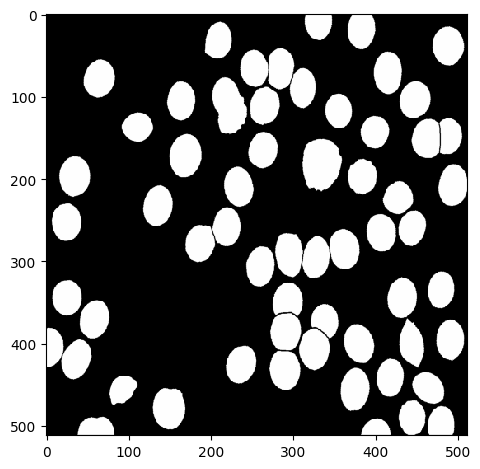

In [3]:
# Define the path to the mask images
train_data_path = '/kaggle/input/blooddata/Mask'  # Path to the mask images
training_masks = os.listdir(train_data_path)  # List of mask filenames
training_masks.sort()  # Sort masks for consistency

# Initialize an array to hold the mask images
# y: A numpy array to store all masks, with shape (number_of_masks, height, width, channels)
y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)  # Initialize with zeros

# Loop through the mask images, resize them, and store them in the y array
index = 0
for x in training_masks:
    path = os.path.join(train_data_path, x)  # Get the full path of the mask
    image = imread(path)  # Read the mask from the path
    image = resize(image, (row, columns), mode='constant', preserve_range=True)  # Resize the mask
    y[index] = image  # Store the resized mask in the y array
    index += 1  # Increment index

# Output the shape of the loaded masks array
print("Shape of training data (masks):", y.shape)

# Check the data type of the masks array
print("Data type of masks:", y.dtype)

# Visualize the first mask in the dataset to verify
imshow(y[0])
plt.show()  # Display the mask

# **Splitting into 80:20 ratio**

In [4]:
# Import necessary library for splitting the dataset
import numpy as np
from sklearn.model_selection import train_test_split  # Used to split the dataset into training and testing sets

# Split the dataset into 80% training and 20% testing
# X: Input images, y: Corresponding masks (labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Subheading: Verifying the Split
# Print the shapes of the training and testing data to verify the split
print("Training images shape:", X_train.shape)
print("Training masks shape:", y_train.shape)
print()
print("Testing images shape:", X_test.shape)
print("Testing masks shape:", y_test.shape)

Training images shape: (1062, 512, 512, 3)
Training masks shape: (1062, 512, 512, 3)

Testing images shape: (266, 512, 512, 3)
Testing masks shape: (266, 512, 512, 3)


# **Visualizing Training and Testing Images**

Displaying the first training image:


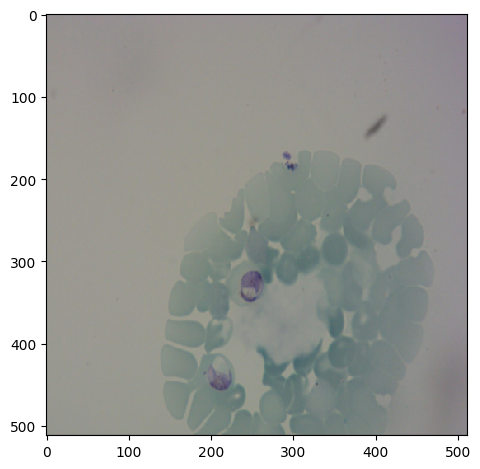

Displaying the corresponding mask for the first training image:


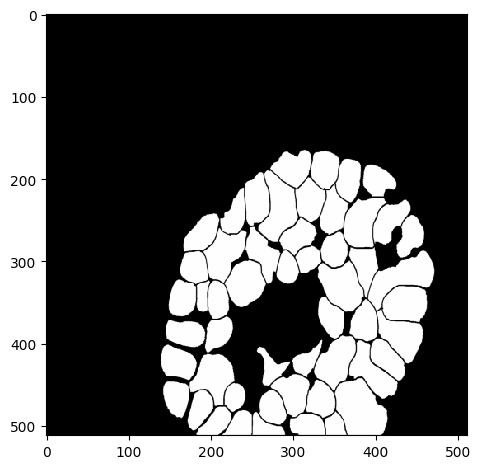

In [5]:
# Visualize the first image in the training set
# X_train contains the training images
print("Displaying the first training image:")
imshow(X_train[0])  # Display the first training image
plt.show()  # Show the plot

# Visualize the corresponding mask (label) for the first image
# y_train contains the corresponding masks for the training images
print("Displaying the corresponding mask for the first training image:")
imshow(y_train[0])  # Display the first mask
plt.show()  # Show the plot

Displaying the first testing image:


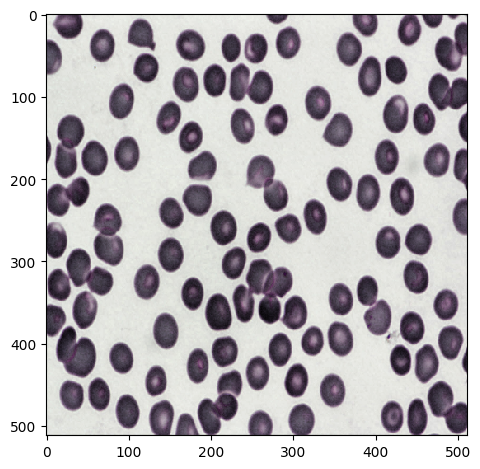

Displaying the corresponding mask for the first testing image:


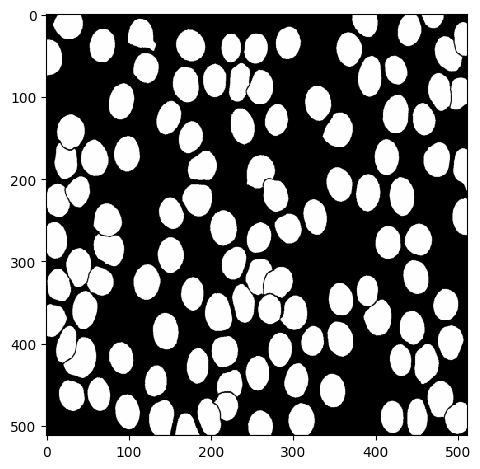

In [6]:
# Visualize the first image in the testing set
# X_test contains the testing images
print("Displaying the first testing image:")
imshow(X_test[0])  # Display the first testing image
plt.show()  # Show the plot

# Visualize the corresponding mask (label) for the first image in the test set
# y_test contains the corresponding masks for the testing images
print("Displaying the corresponding mask for the first testing image:")
imshow(y_test[0])  # Display the first testing mask
plt.show()  # Show the plot

In [7]:
# Convert the masks in the training set (y_train) to boolean type
# This is often done for binary masks, where 0 represents background and 1 represents the object
y_train = y_train.astype('bool')

# Print the data type of the training masks after conversion to confirm
print("Data type of training masks after conversion:", y_train.dtype)

Data type of training masks after conversion: bool


# **Importing Necessary Libraries**

In [8]:
# Keras and TensorFlow are used for building and training the deep learning model
# Keras models and layers provide a high-level interface for defining and training models

# Importing necessary libraries from Keras for model building and training
from keras.models import Model, load_model  # Model allows us to define custom models, load_model for saving/loading models
from keras.layers import Input  # Input layer for defining input shape of the model
from keras.layers import Dropout, Lambda  # Dropout: for regularization, Lambda: to wrap custom functions as layers
from keras.layers import Conv2D, Conv2DTranspose  # Conv2D: for convolutional layers, Conv2DTranspose: for deconvolution (upsampling)
from keras.layers import MaxPooling2D  # MaxPooling2D: for downsampling the feature maps
from keras.layers import concatenate  # concatenate: to merge different layers, especially in U-Net architecture
from keras.callbacks import EarlyStopping, ModelCheckpoint  # EarlyStopping: to stop training if performance stops improving, ModelCheckpoint: to save the best model
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
# Importing backend functions from TensorFlow
import tensorflow.keras.backend as K  # Backend utility functions, often used in custom loss functions or metrics
import tensorflow as tf  # TensorFlow framework, which Keras is built on

# **Metrics for training + validation**

In [9]:
# The Dice Coefficient and Jaccard Index (Intersection over Union, IoU) are commonly used metrics
# in segmentation tasks to evaluate the overlap between predicted masks and ground truth masks.

# Dice Coefficient: Measures the similarity between two samples (higher is better)
# Formula: 2 * (|A ∩ B|) / (|A| + |B|)

def dice_coef(a, b):
    # a: Ground truth mask
    # b: Predicted mask

    hi = a  # Ground truth mask
    pred = b  # Predicted mask

    # Flatten the masks to make the operation element-wise
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator (intersection between ground truth and prediction)
    upper_part = 2 * tf.keras.backend.sum(hi * pred)  # Intersection is multiplied by 2

    # Calculate the denominator (sum of the ground truth and prediction)
    lower_part = tf.keras.backend.sum(hi + pred)

    # Dice Coefficient is the ratio of intersection over the total area
    dice = upper_part / lower_part

    return dice

# Jaccard Index (IoU): Measures the intersection over the union (higher is better)
# Formula: |A ∩ B| / (|A ∪ B|)

def jaccard_index(a, b):
    # a: Ground truth mask
    # b: Predicted mask

    hi = a  # Ground truth mask
    pred = b  # Predicted mask

    # Flatten the masks to make the operation element-wise
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator (intersection between ground truth and prediction)
    numerator = tf.keras.backend.sum(hi * pred)  # Intersection

    # Calculate the denominator (union of ground truth and prediction)
    denominator = tf.keras.backend.sum(hi + pred - hi * pred)  # Union

    # Jaccard Index is the ratio of intersection over union
    iou = numerator / denominator

    return iou

# **Attention R U-net**

In [10]:
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), data_format=data_format)(x)
    print(f"theta_x shape: {K.int_shape(theta_x)}")

    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), data_format=data_format)(g)
    print(f"phi_g shape: {K.int_shape(phi_g)}")

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, (1, 1), strides=(1, 1), data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

In [11]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    if data_format == 'channels_last':
        in_channel = K.int_shape(down_layer)[-1]
    else:
        in_channel = K.int_shape(down_layer)[1]

    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_last':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))

    concate = my_concat([up, layer])
    return concate

In [12]:
# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=(3, 3), stride=(1, 1), padding='same', data_format='channels_last'):
    
    if data_format == 'channels_last':
        input_n_filters = K.int_shape(input_layer)[1]
    else:
        input_n_filters = K.int_shape(input_layer)[-1]

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, (1, 1), strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):

        for i in range(2):
            if i == 0:

                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    out_layer = add([layer, skip_layer])
    return out_layer

In [13]:
#Attention R2U-Net
def att_r2_unet(img_w, img_h, n_label, data_format='channels_last'):
    inputs = Input((img_w, img_h, 3))
    x = inputs
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    
        
    opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
    
    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])
    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model

In [14]:
model = att_r2_unet(512, 512, 3)
model.summary()

theta_x shape: (None, 64, 64, 256)
phi_g shape: (None, 64, 64, 256)
theta_x shape: (None, 128, 128, 128)
phi_g shape: (None, 128, 128, 128)
theta_x shape: (None, 256, 256, 64)
phi_g shape: (None, 256, 256, 64)
theta_x shape: (None, 512, 512, 32)
phi_g shape: (None, 512, 512, 32)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ activation[0][0], │
│                     │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 512, 512,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 512, 512,  │          0 │ activation_1[0][… │
│                     │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512, 512,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 512, 512,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 512, 512,  │          0 │ activation_3[0][… │
│                     │ 64)               │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 512, 512,  │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 512, 512,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 512, 512,  │          0 │ activation_4[0][… │
│                     │ 64)               │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 512, 512,  │     36,928 │ add_3[0][0]     

 Total params: 96,509,863 (368.16 MB)

 Trainable params: 96,509,863 (368.16 MB)

 Non-trainable params: 0 (0.00 B)

# **Checking input format before model fit**

In [15]:
# Print the data types of the training images and masks before conversion
print("Data type of X_train (images) before conversion:", X_train.dtype)
print("Data type of y_train (masks) before conversion:", y_train.dtype)

# Print the types of the training images and masks (should be numpy arrays)
print("Type of X_train:", type(X_train))  # Expected: <class 'numpy.ndarray'>
print("Type of y_train:", type(y_train))  # Expected: <class 'numpy.ndarray'>

X_train = X_train.astype('float32') 
y_train = y_train.astype('float32') 


# Print the data types of the training images and masks after conversion
print("Data type of X_train (images) after conversion:", X_train.dtype)
print("Data type of y_train (masks) after conversion:", y_train.dtype)

Data type of X_train (images) before conversion: uint8
Data type of y_train (masks) before conversion: bool
Type of X_train: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Data type of X_train (images) after conversion: float32
Data type of y_train (masks) after conversion: float32


In [16]:
# Now the shapes should match the model's input format
print(f"Shape of X_train (images): {X_train.shape}")  # Should print (40, 3, 512, 512)
print(f"Shape of y_train (masks): {y_train.shape}")  # Should print (40, 3, 512, 512)


Shape of X_train (images): (1062, 512, 512, 3)
Shape of y_train (masks): (1062, 512, 512, 3)


# **Model Fit**

In [17]:
# Define the file path where the best model will be saved
filepath = "/kaggle/working/model.keras"  # Path to save the best model during training

# Early stopping callback: Stop training if the validation loss doesn't improve after 5 epochs (patience=5)
earlystopper = EarlyStopping(patience=5, verbose=1)

# Model checkpoint callback: Save the model with the lowest validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# List of callbacks to be used during training
callbacks_list = [earlystopper, checkpoint]

# Train the U-Net model with the specified parameters
# validation_split=0.2: 20% of the training data will be used for validation
# batch_size=1: Training will be performed with a batch size of 1
# epochs=5: The model will be trained for 5 epochs
history = model.fit(X_train, y_train, 
                    validation_split=0.2,  # 20% of the training data will be used for validation
                    batch_size=1,          # Set batch size to 1 (this can be increased for faster training)
                    epochs=20,              # Train for 20 epochs
                    callbacks=callbacks_list)  # Use the defined callbacks for early stopping and checkpointing

Epoch 1/20


I0000 00:00:1727186696.658841     113 service.cc:145] XLA service 0x7de970002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727186696.658903     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727186696.658907     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727186721.148236     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - dice_coef: 0.7589 - jaccard_index: 0.6613 - loss: 30.4595
Epoch 1: val_loss improved from inf to 0.23022, saving model to /kaggle/working/model.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 670s 738ms/step - dice_coef: 0.7590 - jaccard_index: 0.6614 - loss: 30.4306 - val_dice_coef: 0.9184 - val_jaccard_index: 0.8593 - val_loss: 0.2302
Epoch 2/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - dice_coef: 0.8769 - jaccard_index: 0.8068 - loss: 0.4018
Epoch 2: val_loss did not improve from 0.23022
849/849 ━━━━━━━━━━━━━━━━━━━━ 621s 732ms/step - dice_coef: 0.8769 - jaccard_index: 0.8068 - loss: 0.4017 - val_dice_coef: 0.8894 - val_jaccard_index: 0.8228 - val_loss: 0.2667
Epoch 3/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - dice_coef: 0.9115 - jaccard_index: 0.8493 - loss: 0.2215
Epoch 3: val_loss improved from 0.23022 to 0.10924, saving model to /kaggle/working/model.keras
849/849 ━━━━━━━━━━━━━━━━━━━━ 627s 738ms/step - dice_coef: 0.9115 - jaccard_index: 0.8

# **Plotting History**

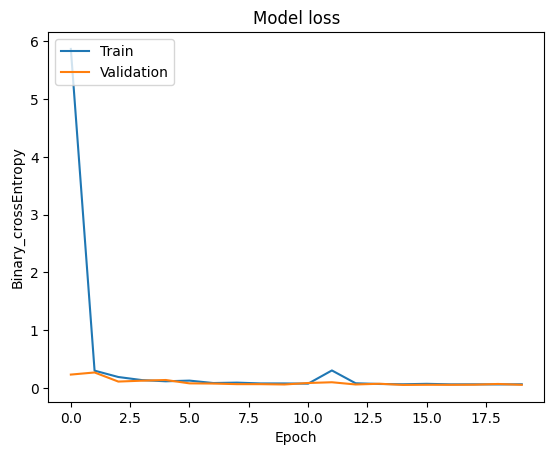

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
print(history.history.keys())


dict_keys(['dice_coef', 'jaccard_index', 'loss', 'val_dice_coef', 'val_jaccard_index', 'val_loss'])


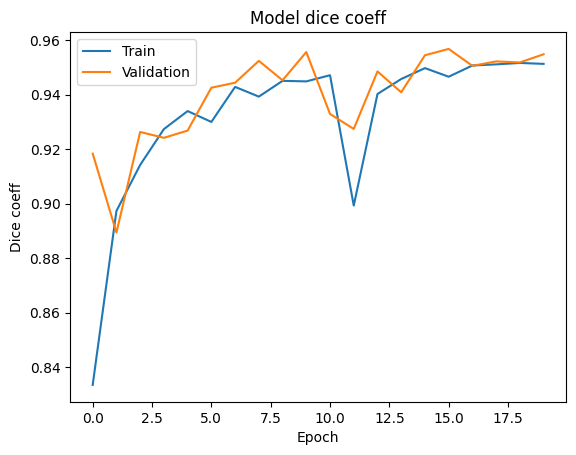

In [20]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

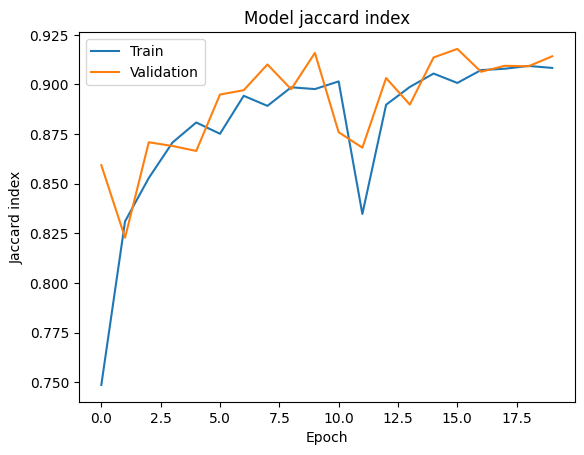

In [21]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Testing**

# **Checking test shape**

In [22]:
print(X_test.shape)
r_x_test = X_test
print(r_x_test.shape)

(266, 512, 512, 3)
(266, 512, 512, 3)


# **Loading Model Weights and Predicting Test Data in Keras**

In [25]:
# Load pre-trained model weights from the specified file
model.load_weights('./model.keras')

# Predict the output for the test data
# r_x_test: test data, assumed to be preprocessed input images
test_preds = model.predict(r_x_test, batch_size=4)

# Print the shape of the predicted output
# This will give the dimensions of the predictions, which should match the test data in terms of batch size and output shape
print(test_preds.shape)

# Print the type of the predictions object
# This is to confirm the data type of the predictions, which is usually a NumPy array after model prediction
print(type(test_preds))

67/67 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step 
(266, 512, 512, 3)
<class 'numpy.ndarray'>


# **Inspecting Prediction Attributes and Visualizing Results**

<class 'numpy.ndarray'>
(266, 512, 512, 3)
float32


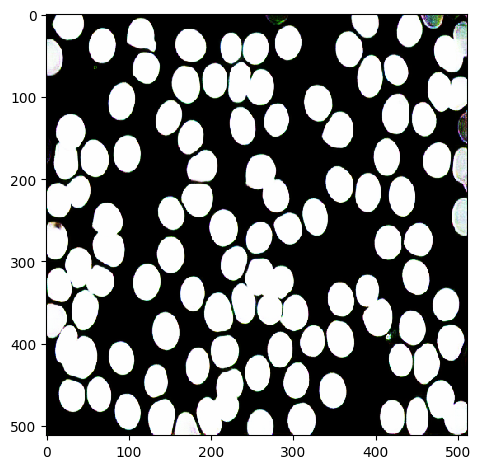

In [26]:
# Print the data type of the predicted results
print(type(test_preds))

# Print the shape of the predicted output
# This will give the dimensions of the predictions, such as (batch_size, height, width, n_classes)
print(test_preds.shape)

# Print the data type of the elements in the predicted array
# This helps to verify the numerical type, e.g., float32, which is often the default for model predictions
print(test_preds.dtype)

# Visualize the first predicted output using imshow
imshow(test_preds[0])

# **Visualizing Predicted and Ground Truth Image Collections**

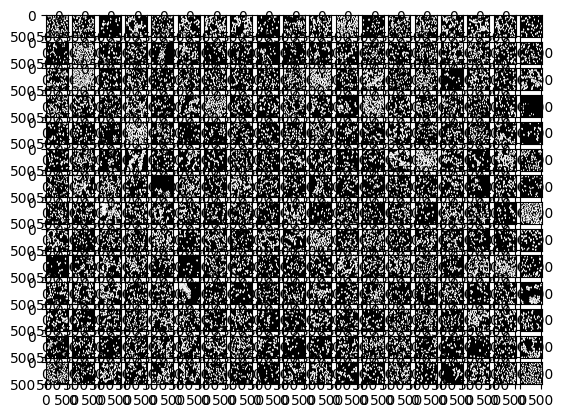

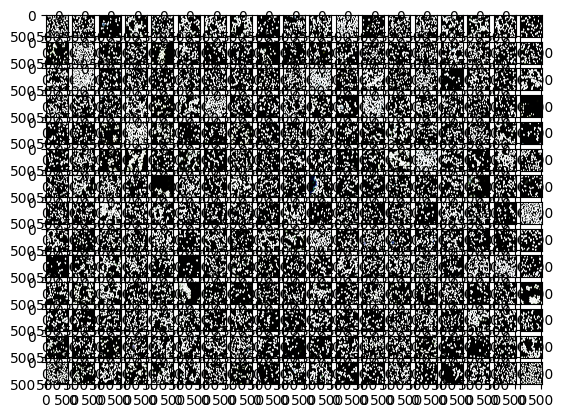

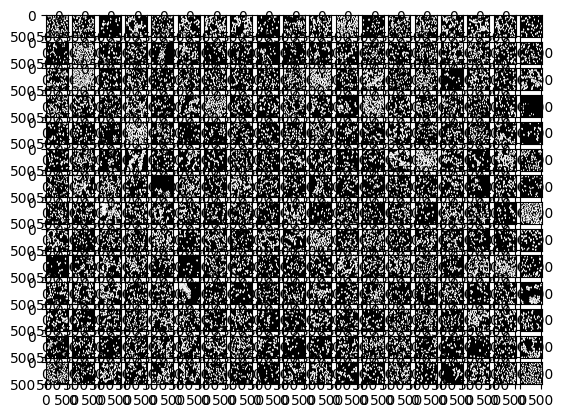

In [27]:
# Import the imshow_collection function from skimage to display a collection of images
from skimage.io import imshow_collection

# Display the collection of predicted images (test predictions)
imshow_collection(test_preds)

# Display the collection of ground truth images for comparison
imshow_collection(y_test)

# **Computing Dice Coefficient and Jaccard Index for Mask Evaluation**

In [28]:
# Dice Coefficient for individual evaluation
# This function computes the Dice Coefficient between two tensors (ground truth and predicted masks)
def dice_coef2(a, b):
    # a: Ground truth mask (scaled down by 255)
    # b: Predicted mask

    # Normalize the ground truth mask by dividing by 255
    hi = a / 255
    pred = b

    # Flatten both ground truth and predicted masks to perform element-wise operations
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator: 2 * intersection between ground truth and predicted masks
    upper_part = 2 * tf.keras.backend.sum(hi * pred)

    # Calculate the denominator: sum of ground truth and predicted masks
    lower_part = tf.keras.backend.sum(hi + pred)

    # Dice Coefficient formula
    dice = upper_part / lower_part

    return dice

# Jaccard Index (IoU) for individual evaluation
# This function computes the Jaccard Index (IoU) between two tensors (ground truth and predicted masks)
def jaccard_index2(a, b):
    # a: Ground truth mask (scaled down by 255)
    # b: Predicted mask

    # Normalize the ground truth mask by dividing by 255
    hi = a / 255
    pred = b

    # Flatten both ground truth and predicted masks
    hi = keras.layers.Flatten()(hi)  # Flatten the ground truth mask
    pred = keras.layers.Flatten()(pred)  # Flatten the predicted mask

    # Calculate the numerator: intersection between ground truth and predicted masks
    numerator = tf.keras.backend.sum(hi * pred)

    # Calculate the denominator: union of ground truth and predicted masks
    denominator = tf.keras.backend.sum(hi + pred - hi * pred)

    # Jaccard Index formula
    iou = numerator / denominator

    return iou

Data type of ground truth mask (y_test[0]): uint8
Data type of predicted mask (test_preds[0]): float32
Dice Coefficient: tf.Tensor(0.9305189, shape=(), dtype=float32)
Jaccard Index: tf.Tensor(0.87006587, shape=(), dtype=float32)


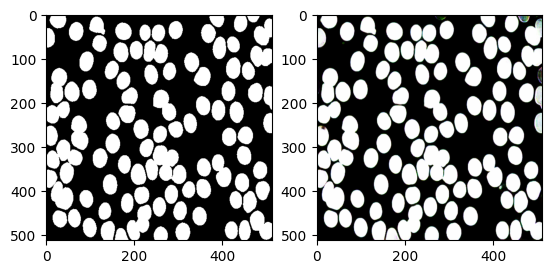

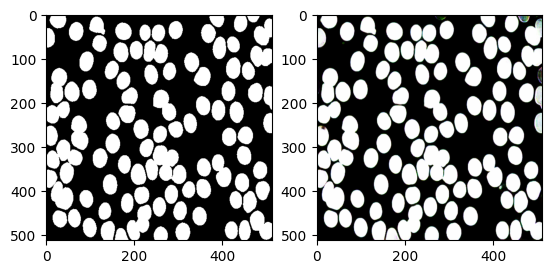

In [29]:
from skimage.io import imshow_collection
# Print the data types of the ground truth and predicted masks for verification
print("Data type of ground truth mask (y_test[0]):", y_test[0].dtype)
print("Data type of predicted mask (test_preds[0]):", test_preds[0].dtype)

# Select the first ground truth and predicted masks for evaluation
i = y_test[0]  # Ground truth mask
j = test_preds[0]  # Predicted mask

# Subheading: Computing the Dice Coefficient and Jaccard Index

# Compute the Dice Coefficient between the ground truth and predicted masks
result = dice_coef2(i, j)
print('Dice Coefficient:', result)

# Compute the Jaccard Index between the ground truth and predicted masks
result2 = jaccard_index2(i, j)
print('Jaccard Index:', result2)



# Create an array to hold the ground truth and predicted masks for visualization
x = np.zeros((2, row, columns, 3))  # Shape to hold two images: ground truth and predicted
x[0] = i  # Ground truth mask
x[1] = j  # Predicted mask

# Visualize the ground truth and predicted masks side by side using imshow_collection
imshow_collection(x)  # Display both masks (ground truth and prediction) for comparison

# **Calculating Average Dice Coefficient and Jaccard Index for Test Dataset**

In [30]:
# Initialize variables to hold the sum of Dice Coefficient and Jaccard Index values
avg_dice = 0  # Variable to accumulate Dice Coefficient values
avg_jaccard = 0  # Variable to accumulate Jaccard Index values

# Subheading: Calculating Metrics for Each Test Sample

# Loop through all the test samples to compute the Dice Coefficient and Jaccard Index
for x in range(len(test_preds)):
    i = y_test[x]  # Ground truth mask for the x-th test sample
    j = test_preds[x]  # Predicted mask for the x-th test sample
    
    # Compute Dice Coefficient and Jaccard Index for the current sample and accumulate the results
    avg_dice += tf.get_static_value(dice_coef2(i, j))  # Add current Dice Coefficient to the total sum
    avg_jaccard += tf.get_static_value(jaccard_index2(i, j))  # Add current Jaccard Index to the total sum


# Calculate the average Dice Coefficient and Jaccard Index by dividing by the number of test samples
avg_dice = avg_dice / len(test_preds)
avg_jaccard = avg_jaccard / len(test_preds)



# Print the average Dice Coefficient and Jaccard Index for the test dataset
print('Average Test Dice Coefficient:', avg_dice)
print('Average Test Jaccard Index:', avg_jaccard)

Average Test Dice Coefficient: 0.9195515015967807
Average Test Jaccard Index: 0.8520194596814034


# **Evaluating Model Performance: Loss, Dice Coefficient, and Jaccard Index**

In [31]:
# Print the lowest training loss during model training
print('Lowest training loss:', min(history.history['loss']))

# Print the lowest validation loss during model validation
print('Lowest validation loss:', min(history.history['val_loss']))

# Subheading: Printing Highest Dice Coefficient

# Print the highest training Dice Coefficient achieved during training
print('Highest training Dice Coefficient:', max(history.history['dice_coef']))

# Print the highest validation Dice Coefficient achieved during validation
print('Highest validation Dice Coefficient:', max(history.history['val_dice_coef']))

# Print the highest training Jaccard Index achieved during training
print('Highest training Jaccard Index:', max(history.history['jaccard_index']))

# Print the highest validation Jaccard Index achieved during validation
print('Highest validation Jaccard Index:', max(history.history['val_jaccard_index']))

Lowest training loss: 0.05962754786014557
Lowest validation loss: 0.05121377483010292
Highest training Dice Coefficient: 0.9516316652297974
Highest validation Dice Coefficient: 0.9567793011665344
Highest training Jaccard Index: 0.9093539714813232
Highest validation Jaccard Index: 0.9179282188415527
